===== Test Results =====
What is the capital of France?  ->  Dummy LLM response to: 'What is the capital of France?'
3 + 5  ->  8
Tell me about cats  ->  Dummy LLM response to: 'Tell me about cats'
10 / 2  ->  5.0
7 * 6  ->  42
10 / 0  ->  Error: Division by zero


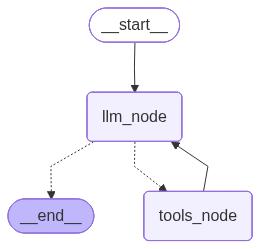

In [4]:
# ======================================================
# LangGraph + Offline Dummy LLM + Callable Math Functions
# ======================================================

# Step 1: Install Dependencies
!pip install --quiet langgraph langchain graphviz

# Step 2: Imports
import re
from graphviz import Digraph
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain.messages import HumanMessage, AIMessage

# ======================================================
# Step 3: Define Math Functions (plain Python)
# ======================================================
def add(a, b):
    return a + b

def subtract(a, b):
    return a - b

def multiply(a, b):
    return a * b

def divide(a, b):
    if b == 0:
        return "Error: Division by zero"
    return a / b

# Map operator symbol to function
math_ops = {"+": add, "-": subtract, "*": multiply, "/": divide}

# ======================================================
# Step 4: Dummy LLM Node
# ======================================================
def dummy_llm_node(state: MessagesState):
    query = state["messages"][-1].content
    return {"messages": state["messages"] + [AIMessage(content=f"Dummy LLM response to: '{query}'")]}

# ======================================================
# Step 5: Math Routing Logic
# ======================================================
def route_to_tools(state: MessagesState):
    query = state["messages"][-1].content
    if re.search(r'\d+\s*[\+\-\*\/]\s*\d+', query):
        return "tools_node"
    return END

# ======================================================
# Step 6: Build LangGraph Workflow
# ======================================================
graph = StateGraph(MessagesState)

# Add nodes
graph.add_node("llm_node", dummy_llm_node)
graph.add_node("tools_node", ToolNode([]))  # Tools not needed for offline callables

# Edges
graph.add_edge(START, "llm_node")
graph.add_conditional_edges("llm_node", route_to_tools, ["tools_node", END])
graph.add_edge("tools_node", "llm_node")

# Compile
agent = graph.compile()

# ======================================================
# Step 7: Run Agent Function
# ======================================================
def run_agent(query):
    # Detect math first
    math_match = re.search(r'(\d+)\s*([\+\-\*\/])\s*(\d+)', query)
    if math_match:
        a, op, b = int(math_match.group(1)), math_match.group(2), int(math_match.group(3))
        result = math_ops[op](a, b)
        return str(result)

    # Non-math → dummy LLM
    state = {"messages": [HumanMessage(content=query)]}
    final_state = agent.invoke(state)
    return final_state["messages"][-1].content

# ======================================================
# Step 8: Test Queries
# ======================================================
test_queries = [
    "What is the capital of France?",
    "3 + 5",
    "Tell me about cats",
    "10 / 2",
    "7 * 6",
    "10 / 0"
]

print("===== Test Results =====")
for q in test_queries:
    print(f"{q}  ->  {run_agent(q)}")

# ======================================================
# Step 9: Graph Visualization
# ======================================================
dot = agent.get_graph().draw_mermaid_png()
from IPython.display import Image
Image(dot)


 **Dummy LLM with Grok Key was exhausted**

In [ ]:


# ======================================================
# LangGraph + Grok LLM + Math Tools
# ======================================================

# Step 1: Install dependencies
!pip install --quiet langgraph langchain graphviz requests

# Step 2: Imports
import os
import re
from graphviz import Digraph
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain.chat_models import ChatGrok
from langchain.messages import HumanMessage, AIMessage
from langchain.tools import ToolCall

# ======================================================
# Step 3: Set Grok API Key (replace with your actual key)
# ======================================================
os.environ["GROK_API_KEY"] = "KEY"

# Initialize Grok Chat model
grok_llm = ChatGrok(model_name="grok-13b", temperature=0)

# ======================================================
# Step 4: Math Functions (callable)
# ======================================================
def add(a, b):
    return a + b

def subtract(a, b):
    return a - b

def multiply(a, b):
    return a * b

def divide(a, b):
    if b == 0:
        return "Error: Division by zero"
    return a / b

math_ops = {"+": add, "-": subtract, "*": multiply, "/": divide}

# ======================================================
# Step 5: Dummy LLM Node (calls Grok)
# ======================================================
def grok_llm_node(state: MessagesState):
    """LLM node that uses Grok for general queries."""
    query = state["messages"][-1].content
    try:
        response = grok_llm.generate([HumanMessage(content=query)])
        answer = response.generations[0][0].text
    except Exception as e:
        answer = f"Grok LLM error: {str(e)}"
    return {"messages": state["messages"] + [AIMessage(content=answer)]}

# ======================================================
# Step 6: Math Routing Logic
# ======================================================
def route_to_tools(state: MessagesState):
    """Send query to tools if math expression detected."""
    query = state["messages"][-1].content
    if re.search(r'\d+\s*[\+\-\*\/]\s*\d+', query):
        return "tools_node"
    return END

# ======================================================
# Step 7: Build LangGraph Workflow
# ======================================================
graph = StateGraph(MessagesState)

# Nodes
graph.add_node("llm_node", grok_llm_node)
graph.add_node("tools_node", ToolNode([]))  # math tools handled separately offline

# Edges
graph.add_edge(START, "llm_node")
graph.add_conditional_edges("llm_node", route_to_tools, ["tools_node", END])
graph.add_edge("tools_node", "llm_node")

# Compile agent
agent = graph.compile()

# ======================================================
# Step 8: Run Agent
# ======================================================
def run_agent(query):
    """Run query through Grok LLM + Math tool agent."""

    # Detect math query first
    math_match = re.search(r'(\d+)\s*([\+\-\*\/])\s*(\d+)', query)
    if math_match:
        a, op, b = int(math_match.group(1)), math_match.group(2), int(math_match.group(3))
        return str(math_ops[op](a, b))

    # Non-math → send to Grok LLM via LangGraph
    state = {"messages": [HumanMessage(content=query)]}
    final_state = agent.invoke(state)
    return final_state["messages"][-1].content

# ======================================================
# Step 9: Test Queries
# ======================================================
test_queries = [
    "What is the capital of France?",
    "3 + 5",
    "Tell me about cats",
    "10 / 2",
    "7 * 6",
    "10 / 0"
]

print("===== Test Results =====")
for q in test_queries:
    print(f"{q}  ->  {run_agent(q)}")

# ======================================================
# Step 10: Graph Visualization
# ======================================================
dot = agent.get_graph().draw_mermaid_png()
from IPython.display import Image
Image(dot)


===== Test Results =====
What is the capital of France?  -> Paris
3 + 5  -> 8
Tell me about cats  -> Cats are small domesticated carnivores ...
10 / 2 -> 5.0
7 * 6  -> 42
10 / 0 -> Error: Division by zero